In [115]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from altair import SortField
import os
from datetime import datetime, timedelta,date
import math
import warnings
import nltk
import re
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from string import digits
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.cluster import KMeans

pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
posts=pd.read_csv("20180823/Posts_ByTag_20180824_230514.csv",encoding='utf-8')
facebook_posts=pd.read_csv("facebook_text/part1/facebook.csv",encoding='utf-8')

In [3]:
posts.shape

(41970, 67)

In [4]:
posts.language.unique()

array(['pt', 'en', 'es', 'th', 'de', 'ru', 'it', 'fr', 'tr', 'pl', 'vi',
       'fa', 'un', 'ko', 'is', 'sr', 'ca', 'sv', 'nl', 'uk', 'ja', 'zh',
       'zh-Hant', 'id', 'cs', 'ky', 'et', 'bg', 'hu', 'my', 'el', 'da',
       'ro', 'sq', 'az', 'no', 'cy', 'ar', 'ta', 'lt', 'hr', 'mr', 'rm',
       'tl', 'hi', 'sk', 'gl', 'vo', 'la', 'mn', 'co', 'nn', 'uz', 'gv',
       'ml', 'fi', 'lo', 'bn', 'ms', 'sl', 'ur', 'fy', 'tk', 'mk', 'iw',
       'ka', 'ne', 'gd', 'or', 'sco'], dtype=object)

In [5]:
#### Let us create functions to handle date columns and divide the tags into 5 columns
def convertToDateString(dates):

    try:
        if math.isnan(dates)==True:
            return ''
    
        return (datetime(1970, 1, 1) + timedelta(milliseconds=dates)).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return ''

def convertStringToDate(dateString,formatString='%Y-%m-%d %H:%M:%S'):
    if dateString=='':
        return ''
    dates=datetime.strptime(dateString,formatString)
    return dates.date()

def getDaysBetweenDates(date1,date2):
    delta=date1-date2
    return delta.days

def getTagList(tagName,element_index=0):
    
    tagName=tagName.replace("[","")
    tagName=tagName.replace("]","")
    tagName=tagName.replace("'","")
    tagList= tagName.split(",")
    tagList=[tag.strip() for tag in tagList]
    try:
        return tagList[element_index]
    except:
        return ""

### Create a function to preprocess the posts
1. Remove Posts which are responses
2. Drop inReponseToPostId column
3. Extract only wanted columns
4. Clean the dates and extract the date from datetime
5. keep only the english posts



In [6]:
import os
from datetime import datetime, timedelta,date
import math
def convertToDateString(dates):

    try:
        if math.isnan(dates)==True:
            return ''
    
        return (datetime(1970, 1, 1) + timedelta(milliseconds=dates)).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return ''

def convertStringToDate(dateString,formatString='%Y-%m-%d %H:%M:%S'):
    if dateString=='':
        return ''
    dates=datetime.strptime(dateString,formatString)
    return dates.date()

def getDaysBetweenDates(date1,date2):
    delta=date1-date2
    return delta.days

def getTagList(tagName,element_index=0):
    
    tagName=tagName.replace("[","")
    tagName=tagName.replace("]","")
    tagName=tagName.replace("'","")
    tagList= tagName.split(",")
    tagList=[tag.strip() for tag in tagList]
    try:
        return tagList[element_index]
    except:
        return ""

def postpreprocessing(posts):
    #Remove Posts which are responses
    
    #Remove the column inReponseToPostId from the dataframe
    
    posts['hasImportedUrl']=pd.notnull(posts['importedUrl'])
    posts['hasWebCanonicalUrl']=pd.notnull(posts['webCanonicalUrl'])
    posts['hasImportedPublishedAt']=pd.notnull(posts['importedPublishedAt'])
    posts=posts[posts['language']=='en']
    #Let us only extract columns needed for Analysis
    cols=['id','scrappedDate','createdAt','firstPublishedAt','latestPublishedAt','updatedAt','imageCount','linksCount',
      'readingTime','recommends','responsesCreatedCount','tagsCount','wordCount','notifyFacebook','notifyFollowers',
     'notifyTwitter','title','subTitle','searchTag','collectionId','creatorId','isSubscriptionLocked',
     'totalClapCount','hasUnpublishedEdits','hasImportedUrl','hasWebCanonicalUrl','hasImportedPublishedAt','tags_name','uniqueSlug','inResponseToPostId','audioVersionDurationSec',
     ]
    posts_extracted=posts[cols]
    
    #Clean the dates
    posts_extracted['createdDatetime']=posts_extracted['createdAt'].apply(convertToDateString)
    posts_extracted['firstPublishedDatetime']=posts_extracted['firstPublishedAt'].apply(convertToDateString)
    posts_extracted['latestPublishedDatetime']=posts_extracted['latestPublishedAt'].apply(convertToDateString)
    posts_extracted['updatedDatetime']=posts_extracted['updatedAt'].apply(convertToDateString)
    
    
    #Extract date from date time strings
    posts_extracted['firstPublishedDate']=posts_extracted['firstPublishedDatetime'].apply(convertStringToDate,args=('%Y-%m-%d %H:%M:%S',))
    posts_extracted['createdDate']=posts_extracted['createdDatetime'].apply(convertStringToDate,args=('%Y-%m-%d %H:%M:%S',))
    posts_extracted['latestPublishedDate']=posts_extracted['latestPublishedDatetime'].apply(convertStringToDate,args=('%Y-%m-%d %H:%M:%S',))
    posts_extracted['updatedDate']=posts_extracted['updatedDatetime'].apply(convertStringToDate,args=('%Y-%m-%d %H:%M:%S',))
    
    cols_drop=['createdAt','firstPublishedAt','latestPublishedAt','updatedAt']
    posts_extracted=posts_extracted.drop(columns=cols_drop)
    
    #A post can have maximum of 5 tags. So instead of having it as one column let us divide them into 5 columns. Also, ideally the 
    #article should be tagged such that the most relevant tag should come at the beginning
    
    posts_extracted['Tag1']=posts_extracted['tags_name'].apply(getTagList,args=(0,))
    posts_extracted['Tag2']=posts_extracted['tags_name'].apply(getTagList,args=(1,))
    posts_extracted['Tag3']=posts_extracted['tags_name'].apply(getTagList,args=(2,))
    posts_extracted['Tag4']=posts_extracted['tags_name'].apply(getTagList,args=(3,))
    posts_extracted['Tag5']=posts_extracted['tags_name'].apply(getTagList,args=(4,))
    
    key_list=['Facebook','facebook']
    title_list=['customer support','customer service','songs','hack facebook account from mobile','hack fb account from mobile','customer care']
    pattern='|'.join(key_list)
    title_pattern='|'.join(title_list)
    posts_extracted=posts_extracted[posts_extracted.tags_name.str.contains(pattern)]
    posts_extracted=posts_extracted[~ posts_extracted.title.str.contains("(?i)"+title_pattern)]
    posts_extracted=posts_extracted[posts_extracted['firstPublishedDate']>=convertStringToDate('2016-01-01',formatString='%Y-%m-%d')]
    posts_extracted.drop_duplicates(inplace=True)
    posts_extracted.drop_duplicates(['id'],inplace=True)
    
   
    return posts_extracted

In [7]:
posts=postpreprocessing(posts)
posts.shape

(29807, 40)

In [8]:
posts=pd.merge(posts,facebook_posts,on='id',how='inner')

In [188]:
posts=posts[pd.notnull(posts['content'])]
posts.shape

(27317, 42)

### Distribution of Facebook Posts since 2016

In [10]:
posts_day=posts.groupby(['firstPublishedDate'])['id'].count().reset_index().rename(columns={'id':'NumberOfPosts'})
posts_day.head()                    

,firstPublishedDate,NumberOfPosts
0,2016-01-01,14
1,2016-01-02,8
2,2016-01-03,8
3,2016-01-04,17
4,2016-01-05,21


In [11]:
posts_day['firstPublishedDate']=pd.to_datetime(posts_day['firstPublishedDate'])
posts_day.dtypes

firstPublishedDate    datetime64[ns]
NumberOfPosts         int64         
dtype: object

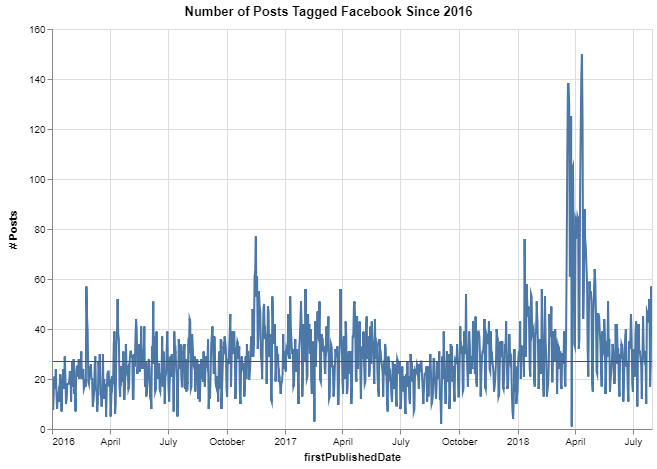

In [12]:
chart=alt.Chart(posts_day).mark_line().encode(
    x='firstPublishedDate:T',
    y='NumberOfPosts:Q',
    tooltip=['NumberOfPosts'],
   
).properties(
    title='Number of Posts Tagged Facebook Since 2016',
    height=400,
    width=600
).interactive()
chart.encoding.y.title = '# Posts'

rule = alt.Chart(posts_day).mark_rule(color='red').encode(
    y='median(NumberOfPosts)',
    size=alt.value(1)
)




chart+rule

### We can a spike in the number of posts tagged facebook from mid march to mid april. We can zoom in and check the details of the spike. 

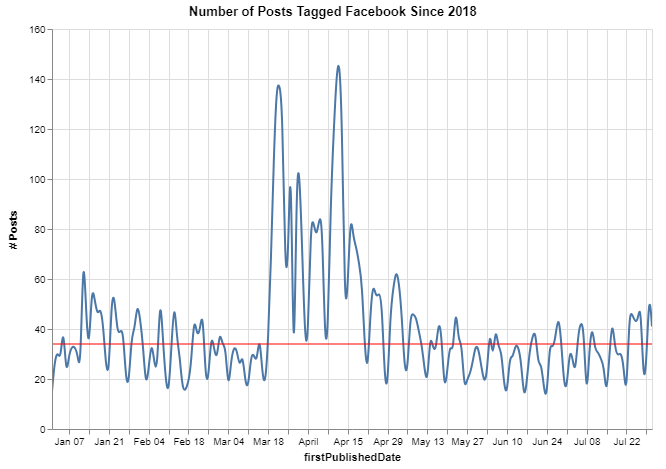

In [13]:

chart=alt.Chart(posts_day.loc[posts_day['firstPublishedDate']>=pd.to_datetime('2018-01-01')]).mark_line(interpolate='basis').encode(
    x='firstPublishedDate:T',
    y='NumberOfPosts:Q',
    tooltip=['NumberOfPosts']
).properties(
    title='Number of Posts Tagged Facebook Since 2018',
    height=400,
    width=600
).interactive()
chart.encoding.y.title = '# Posts'
rule = alt.Chart(posts_day.loc[posts_day['firstPublishedDate']>=pd.to_datetime('2018-01-01')]).mark_rule(color='red').encode(
    y='median(NumberOfPosts)',
    size=alt.value(1)
)



chart + rule



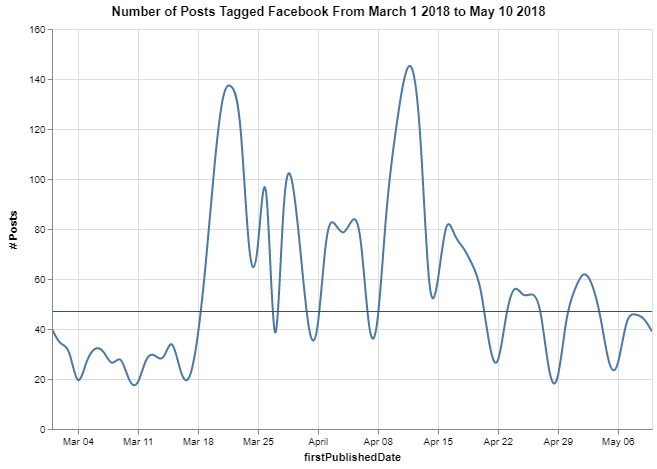

In [14]:
chart=alt.Chart(posts_day.loc[(posts_day['firstPublishedDate']>=pd.to_datetime('2018-03-01')) & (posts_day['firstPublishedDate']<=pd.to_datetime('2018-05-10'))]).mark_line(interpolate='basis').encode(
    x='firstPublishedDate:T',
    y='NumberOfPosts:Q',
    tooltip=['NumberOfPosts']
).properties(
    title='Number of Posts Tagged Facebook From March 1 2018 to May 10 2018',
    height=400,
    width=600
).interactive()
chart.encoding.y.title = '# Posts'
rule = alt.Chart(posts_day.loc[(posts_day['firstPublishedDate']>=pd.to_datetime('2018-03-01')) & (posts_day['firstPublishedDate']<=pd.to_datetime('2018-05-10'))]).mark_rule(color='red').encode(
    y='median(NumberOfPosts)',
    size=alt.value(1)
)



chart + rule

### What are the most frequent tags and how has the top 10 tags, changed pre and post scandal?

#### Overall distribution of tags 
This requires us to remove facebook from all the tags

In [15]:
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image
import random

def getText(text_list):
    text=""
    for txt in text_list:
        #print(txt)
        txt=txt.replace("'","")
        text = text+" "+txt
        #"".join(txt).encode('utf-8').strip()
        #text
    text=text.lower()
    return text
    
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)
def generateWordcloud(text):
    

    stopwords = set(STOPWORDS)
    stopwords.add("facebook")
    stopwords.add("social media")
    wordcloud = WordCloud(relative_scaling=0.5,max_words=1000,stopwords=stopwords,width=1600, height=900, colormap=matplotlib.cm.inferno).generate(text)
    #facebook_mask = np.array(Image.open("mark_2.png"))
    #facebook_mask = np.array(facebook_mask.convert('RGB'))
    #wordcloud = WordCloud(background_color='white',mask=facebook_mask,max_words=300,stopwords=stopwords,width=2000, height=1200, colormap=matplotlib.cm.inferno).generate(text)
    #image_colors = ImageColorGenerator(facebook_mask)
    #plt.figure(figsize=(10,10), dpi=2000)
    #plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis("off")
  
    
    
    

In [16]:
tags_text=getText(posts['tags_name'])

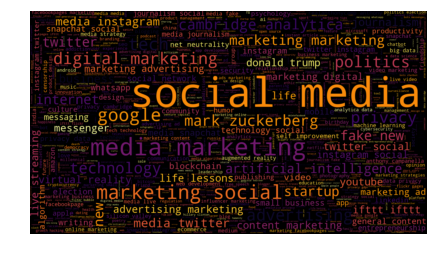

In [17]:
generateWordcloud(tags_text)

### Social Media is the most commonly used tag also with facebook. Let us understand what the Distribution of tags look like pre and post scandal?

In [18]:
from collections import Counter
def getTagsCount(tags):
    tags=[tag.replace("[","") for tag in tags]
    tags=[tag.replace("]","") for tag in tags]
    tags_str=""
    for tag in tags:
        tags_str = tags_str+","+"".join(tag).strip()
    tags_str=tags_str.strip(",")
    words=tags_str.split(",")
    words=[x for x in words if x]
    words=[x.strip() for x in words]
    words=[x.strip("'") for x in words]
    counts = Counter(words)
    tags_count=pd.DataFrame.from_dict(counts,orient="index")
    tags_count=tags_count.reset_index()

    tags_count=tags_count.rename(columns={'index':'Tags', 0:'NumberOfPosts'})
    return tags_count

In [19]:
posts['firstPublishedDate']=pd.to_datetime(posts['firstPublishedDate'])

pre_scandal=posts.loc[posts['firstPublishedDate']<pd.to_datetime('2018-03-17')]
post_scandal=posts.loc[posts['firstPublishedDate']>=pd.to_datetime('2018-03-17')]

In [20]:
pre_scandal_tag_count=getTagsCount(pre_scandal['tags_name'])
post_scandal_tag_count=getTagsCount(post_scandal['tags_name'])
pre_scandal_tag_count=pre_scandal_tag_count[pre_scandal_tag_count['Tags']!="Facebook"]
post_scandal_tag_count=post_scandal_tag_count[post_scandal_tag_count['Tags']!="Facebook"]


Text(0.5,1,'Top 10 Tags Associated with Facebook Pre Scandal')

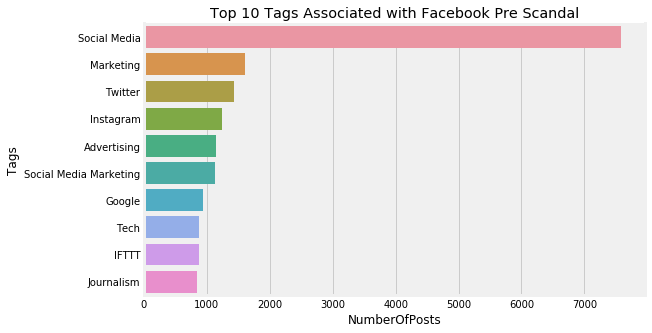

In [21]:
#sns.set(context='notebook',font='sans-serif', font_scale=2, color_codes=True, rc=None)
top20_pre_scandal_count=pre_scandal_tag_count.sort_values('NumberOfPosts',ascending = False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x='NumberOfPosts',y='Tags',data=top20_pre_scandal_count).set_title("Top 10 Tags Associated with Facebook Pre Scandal")

Text(0.5,1,'Top 10 Tags Associated with Facebook Post Scandal')

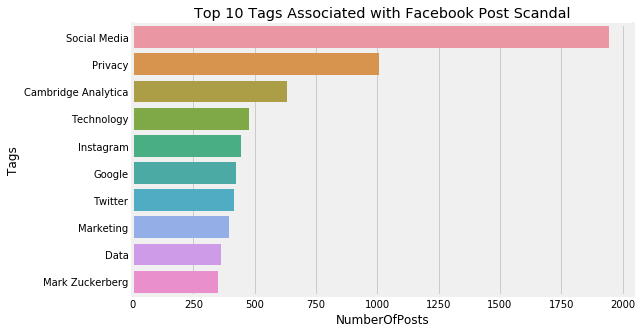

In [22]:
top20_post_scandal_count=post_scandal_tag_count.sort_values('NumberOfPosts',ascending = False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x='NumberOfPosts',y='Tags',data=top20_post_scandal_count).set_title("Top 10 Tags Associated with Facebook Post Scandal")

In [23]:
pre_scandal_tag_count[pre_scandal_tag_count['Tags']=='Privacy']

,Tags,NumberOfPosts
152,Privacy,481


In [24]:
post_scandal_tag_count[post_scandal_tag_count['Tags']=='Privacy']

,Tags,NumberOfPosts
21,Privacy,1005


In [25]:
posts['is_post_scandal']=posts['firstPublishedDate'].apply(lambda x:x>=pd.to_datetime('2018-03-17'))

In [26]:
posts['is_post_scandal'].value_counts()

False    21198
True     6119 
Name: is_post_scandal, dtype: int64

In [27]:
getTagsCount(posts['tags_name']).shape

(9827, 2)

### There are 9830 tags associated with Facebook. We have seen the Privacy and Data have emerged into the Top 10. So let us take the stories tagged Privacy and Data and see what Themes emerge

In [51]:
text=posts.loc[(posts['tags_name'].str.contains("Privacy|Data")),'content']
print('Number of Corpus :',len(text))

Number of Corpus : 2107


#### Data Preprocessing
1. Remove stopwords
2. Remove Punctuations, Numbers 
3. Lemmatize the corpus - bring it to the root(dictionary) form of the word

In [52]:
stopwords = nltk.corpus.stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
regex = re.compile('[%s]' % re.escape(string.punctuation))
remove_digits = str.maketrans('', '', digits)
replace_are=[]

In [108]:
def clean_doc(text):
    
    text=text.replace("’ve"," have")
    text=text.replace("’re"," are")
    text=text.replace("’s","")
    text=text.replace("n’t"," not")
    text=text.replace("’m"," am")
    text=text.replace("—"," ")
    text=text.replace("years","year")
    text=text.replace("websites","website")
    text=text.replace("platforms","platform")
    text=text.replace("things","thing")
    text=text.replace("settings","setting")
    text=text.replace("photos","photo")
    text=text.replace("laws","law")
    text=text.replace("millions","million")
    text=text.replace("businesses","business")
    text=text.replace("consumers","consumer")
    text=text.replace("developers","developer")
    text=text.replace("customers","customer")
    text=text.replace("friends","friend")
    text=text.replace("individuals","individual")
    text=text.replace("days","day")
    text=text.replace("devices","device")
    text=text.replace("products","product")
    text=text.replace("months","month")
    text=text.replace("users","user")
    text=text.replace("ways","way")
    text=text.replace("videos","videos")
    text=text.replace("policies","policy")
    text_clean=" ".join([i for i in text.lower().split() if i not in stopwords])
    #text_clean=" ".join([i for i in text_clean.split() if re.search('[a-zA-Z]', i)])
    text_clean=regex.sub('', text_clean)
    #text_clean=text_clean.translate(remove_digits)
    text_clean=''.join([ch for ch in text_clean if not re.search('[0-9]',ch)])
    text_clean=text_clean.replace('“',"")
    text_clean=text_clean.replace("”","")
    text_clean=text_clean.replace(" fb "," facebook ")
    text_clean=text_clean.replace("’","")
    
    text_clean=" ".join([wordnet_lemmatizer.lemmatize(i,'v') for i in text_clean.split()])
    text_tokenise=[text for text in text_clean.split() if text!='—']
    return text_tokenise

In [109]:
clean_doc("I collected ruppess for collect in collect's  don’t videos")

['collect', 'ruppess', 'collect', 'collect', 'videos']

### 2. Tf-IDF Vectoriser
Tf-idf indicates the importance of a word in a document in a collection of documents. Term Frequency (tf) calculates the number of occurrences of a word in a document.
Inverse Document Frequency (idf) calculates how frequent is a word in the entire corpus. If a word occurs in every document in the corpus - it is not an rare or an very important word.
We will use Tf-IDF to measure similarity between documents and cluster them 

The features to tune in this step are:
1. max_df : This ignores words that are present in more than x% of the documents. For example if max_df=0.8, then it excludes words present in more than 80% of the documents
2. min_df : This considers only words that are present in atleast x% of the documents. 
3. ngram_range: This is the number of n-grams to consider

In [110]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,min_df=0.1, stop_words='english',use_idf=True, tokenizer=clean_doc, ngram_range=(1,3))


In [111]:
tfidf_matrix = tfidf_vectorizer.fit_transform(text)
terms = tfidf_vectorizer.get_feature_names()

In [112]:
terms

['ability',
 'able',
 'abuse',
 'accept',
 'access',
 'access data',
 'accord',
 'account',
 'act',
 'action',
 'active',
 'activity',
 'actually',
 'ad',
 'add',
 'address',
 'ads',
 'advertise',
 'advertisers',
 'affect',
 'age',
 'ago',
 'agree',
 'algorithms',
 'allow',
 'alway',
 'amazon',
 'analytica',
 'analytica scandal',
 'answer',
 'app',
 'appear',
 'apple',
 'apply',
 'approach',
 'apps',
 'article',
 'ask',
 'attention',
 'audience',
 'available',
 'aware',
 'away',
 'bad',
 'base',
 'begin',
 'believe',
 'benefit',
 'best',
 'better',
 'big',
 'billion',
 'bite',
 'blog',
 'brand',
 'breach',
 'break',
 'bring',
 'build',
 'business',
 'business model',
 'buy',
 'ca',
 'cambridge',
 'cambridge analytica',
 'cambridge analytica scandal',
 'campaign',
 'care',
 'case',
 'cause',
 'ceo',
 'certain',
 'challenge',
 'change',
 'check',
 'choose',
 'claim',
 'clear',
 'click',
 'close',
 'collect',
 'collect data',
 'collection',
 'come',
 'comment',
 'community',
 'company',
 

We can see there are words related to user data, facebook collection, cambridge analytica scandal. Let us now get the similar documents. Cosine distance can be used to get the distance between two corpus

### 3. Calculate Cosine Distance
Cosine Distance is defined as 1- Cosine Similarity

In [113]:
dist=1-cosine_similarity(tfidf_matrix)

### 4. Clustering Documents
We will use k-means to cluster similar documents based on tf-idf. As a first step, we will have to decide on the number of clusters.

In [118]:
n_cluster = range(1,21)
all_inertia = []
for n in n_cluster:
    model = KMeans(n_clusters=n)
    model.fit(tfidf_matrix)
    int_value = model.inertia_
    all_inertia.append(int_value)

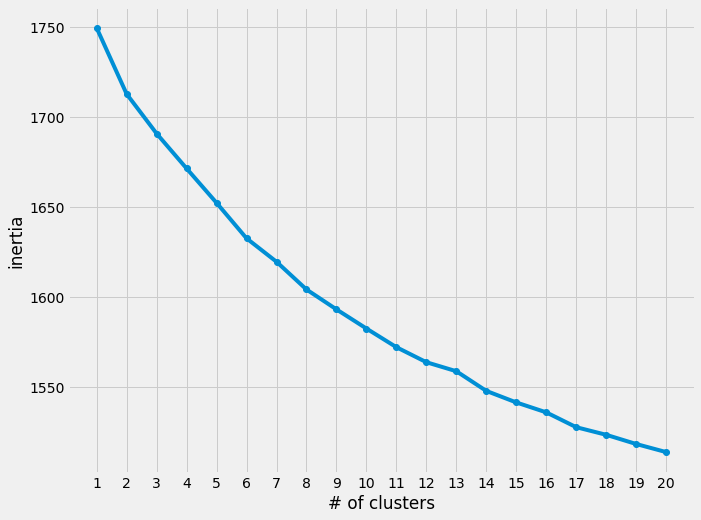

In [119]:
plt.figure(figsize=(10,8))
plt.plot(n_cluster,all_inertia,'-o')
plt.xticks(n_cluster,n_cluster)
plt.ylabel("inertia")
plt.xlabel("# of clusters")
plt.show()

There is no significant elbow - But we can see that after 12 clusters, the drop is not very signficant for each clusters. So , let us calculate 12 clusters

In [122]:
model = KMeans(n_clusters=12,random_state=123)
model.fit(tfidf_matrix)
print("Sum of Squared Distances :", str(model.inertia_))


Sum of Squared Distances : 1564.6575121704461


In [123]:
from sklearn.externals import joblib
joblib.dump(model,'KMeans_Model.pkl')

['KMeans_Model.pkl']

In [124]:
clusters = model.labels_.tolist()
Counter(clusters)

Counter({0: 270,
         1: 148,
         2: 106,
         3: 142,
         4: 102,
         5: 332,
         6: 27,
         7: 156,
         8: 52,
         9: 433,
         10: 163,
         11: 176})

Lot of stories belong to cluster 9. Let us look at the top terms in each of the cluster. This will also help us understand the clusters better

In [127]:
privacy_posts=posts.loc[(posts['tags_name'].str.contains("Privacy|Data"))]
privacy_posts['clusters']=clusters

In [129]:
privacy_data=privacy_posts[['content','tags_name','clusters']]

In [130]:
privacy_data.head()

content  \
73   Panasonic, Facebook develop cold storage Blu-ray data archive systems for data centers\r\nPanasonic Corporation has announced that it has developed freeze-ray, an Optical Disc-Based Data Archive System in collaboration with Facebook. By collaborating with Facebook, Panasonic was able to design freeze-ray to meet the growing demand for more efficient and sustainable ways to store and access cold data — infrequently or never accessed data stored for the long term — in the world’s data centers.\r\nThe freeze-ray solution reduces data center operating costs and energy use with strong data integrity. This data archiving solution provides optimal cold storage for protecting data integrity and reducing costs in data centers thanks to the special characteristics of optical discs, including their longevity, immutability, backward compatibility, low power consumption and tolerance to environmental changes. Both companies see the freeze-ray data archiving solution, incorporating hundreds of optical discs, as a viable solution for data centers to enable the industry to enjoy the benefits of the solution with greater economies of scale.\r\nPanasonic’s contribution to the effort was its high-density optical technology, key devices (optical discs, drives and related robotics) and library software to control the system easily in the data center. Facebook collaborated by providing its unmatched expertise in designing, deploying, managing and servicing storage systems in data centers. In addition, Facebook provided with technical and real-world data center feedback. Both companies have been working on two generations of the freeze-ray solution. Facebook is deploying the first-generation 100 GB Blu-ray Disc-based archive system into its data centers now, and expects deployment of the second-generation 300GB Archival Disc-based archive system later in 2016.\r\n“As Facebook continues to grow, we needed to address some of our fundamental engineering challenges with an efficient, low-cost and sustainable solution that matches our speed and exabyte-scale of data,” said Jason Taylor, PhD, VP of Infrastructure, Facebook. “We’re seeing exponential growth in the number of photos and videos being uploaded to Facebook, and the work we’ve done with Panasonic is exciting because optical storage introduces a medium that is immutable, which helps ensure that people have long-term access to their digital memories.”\r\n“Panasonic is delighted by the opportunity to collaborate with Facebook, with its strong position and influence in the data storage market and expertise necessary to develop the optical data archiver in validation with actual data center environments,” said Yasuji Enokido, President of Panasonic’s AVC Networks Company.\r\nBoth companies plan to continue to collaborate in the study of and eventual development of next- generation systems utilizing higher densities of 500 GB-and one-terabyte Archival Discs to realize a multi petabyte cold storage archive system.\r\nTags: Blu-ray, data archive, Data Center, disk, Facebook, Panasonic, Storage\r\nOriginally published at tech.firstpost.com on January 6, 2016.\r\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

#### What are the top tags in each cluster?

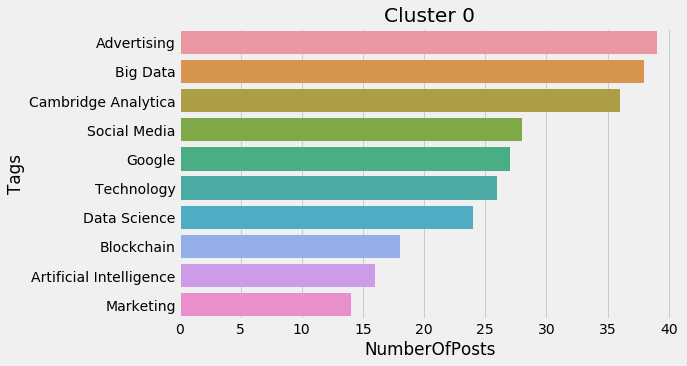

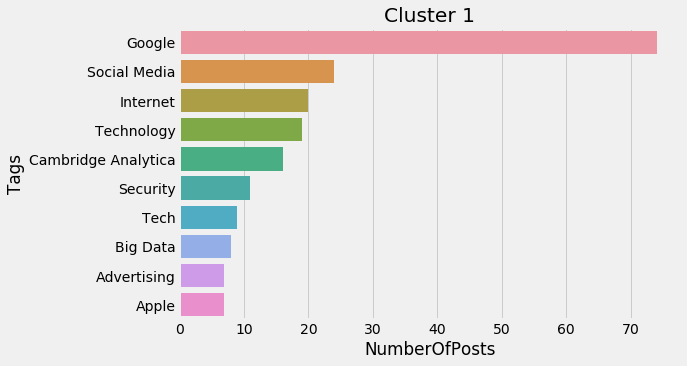

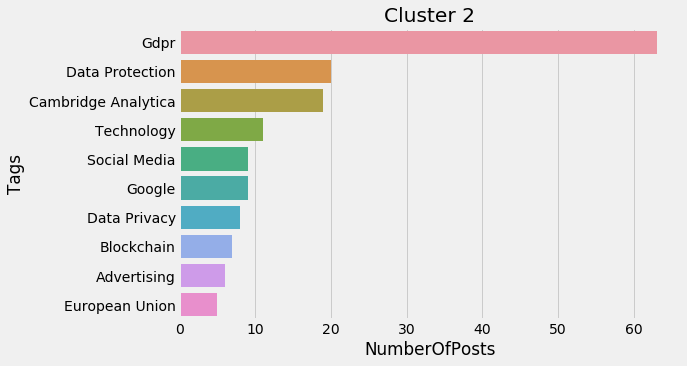

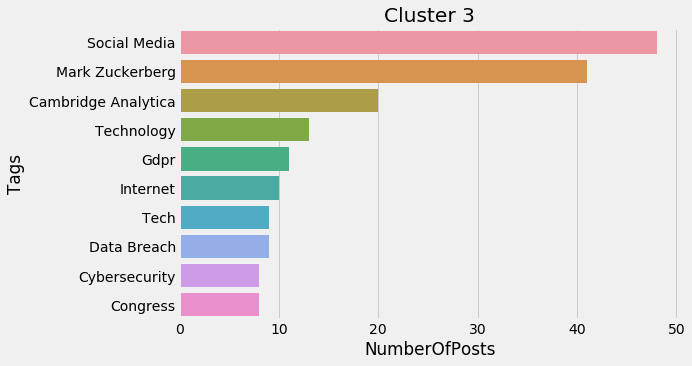

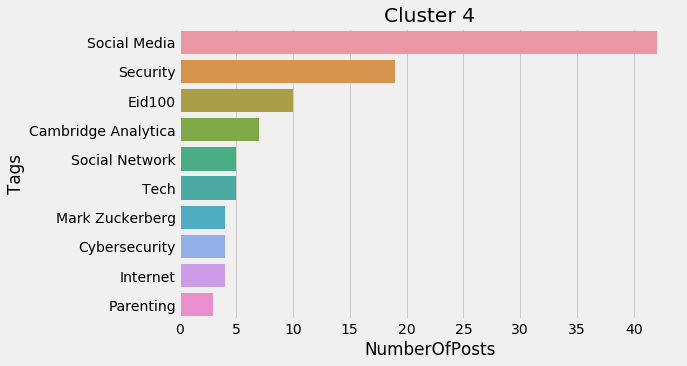

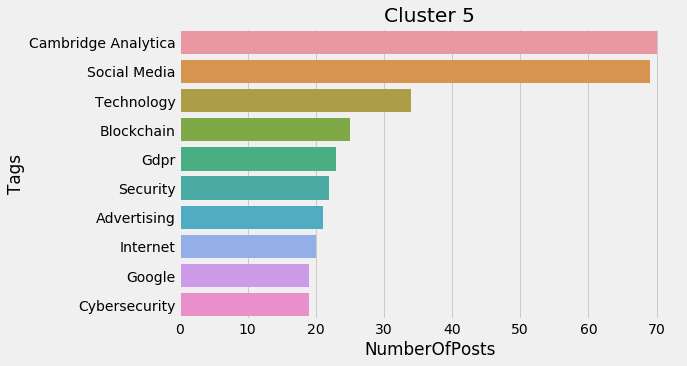

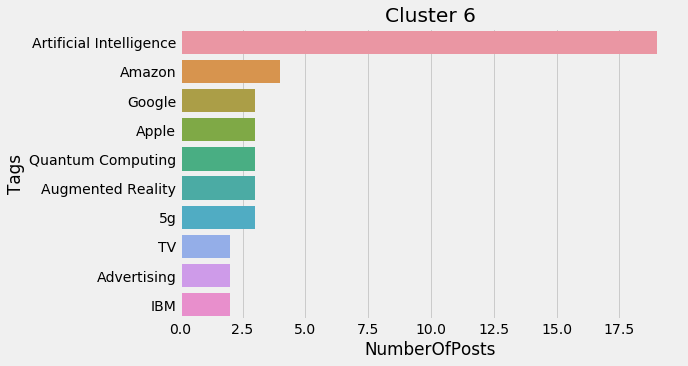

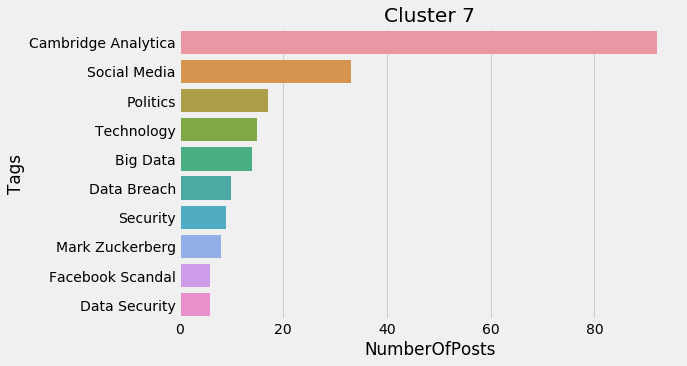

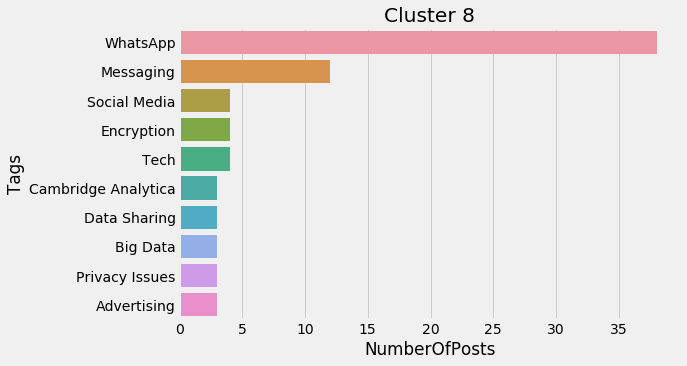

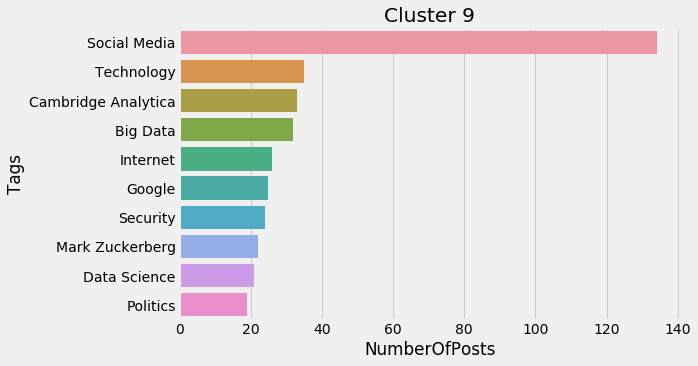

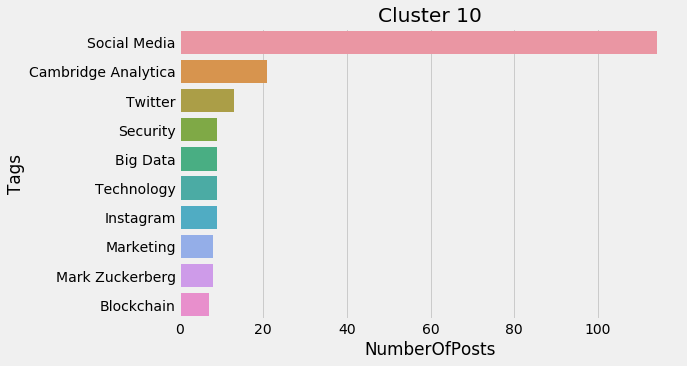

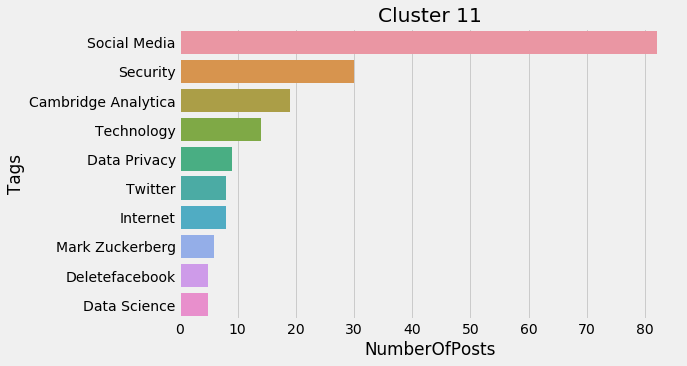

In [180]:
tags_cluster=[]


for i in range(0,12):
    tags_cluster.append(getTagsCount(privacy_data.loc[privacy_data['clusters']==i,'tags_name']))
    data=tags_cluster[i]
    top_10=data[(data['Tags']!='Facebook') & (data['Tags']!='Privacy') & (data['Tags']!='Data')].sort_values('NumberOfPosts',ascending = False).head(10)
    #plt.subplot(6,2,i+1)
    plt.figure(figsize=(8,5))
    sns.barplot(x='NumberOfPosts',y='Tags',data=top_10).set_title("Cluster "+str(i))

#plt.savefig("Cluster_Tags.png")   

#### Number of posts in each cluster?

Text(0.5,1,'Number of Posts in each Cluster')

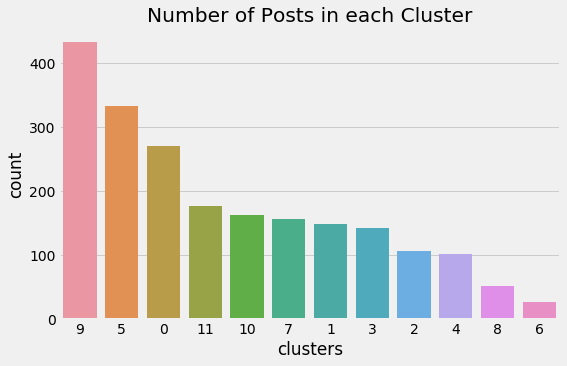

In [182]:
plt.figure(figsize=(8,5))
sns.countplot(privacy_data['clusters'],order=privacy_data['clusters'].value_counts().sort_values(ascending=False).index).set_title("Number of Posts in each Cluster")

In [183]:
privacy_data[privacy_data['tags_name'].str.contains('Eid100')].head(2)

content  \
6018  Facebook: Nothing “Fine” About Their Fine Print\r\nIt was probably a boring Wednesday afternoon that you came home from school, threw your bags on the floor, and jumped in front of the TV. You remembered everyone at school was talking about this new website that allows you to keep up with everyone from school, even the popular kids. It’s free and gives unlimited access to all their pictures, all their conversations, and basically a VIP internet pass to their seemingly perfect lives. You log onto your computer and create an account for this website within minutes. First name; Last name; E-mail address; Age; Gender; you enter all of this information, and more, without any hesitation, check that “Agree to Terms of Use” box, and hit Enter.\r\nYou were now on Facebook.\r\nWithin a few hours, you’ve gone through many profiles. You learned that Sarah from Biology has three sisters that all look alike; that Allen from Calculus didn’t like the new Harry Potter movie; and that Rishi and Tina are making plans to go ice skating at Nathan Phillips Square on Saturday evening at 6pm. You now know the intimidate details of their lives, while in reality, you aren’t actually friends and would likely never discuss such personal matters.\r\nYou can’t help but wonder what everyone knows about your life. Could it really be that easy to get a look into the personal lives of complete strangers? YES. It is really that easy. And I hate to break it to you- but not only can Facebook see what you post when you post it, they can do a whole lot more with your pictures, posts, updates, and personal information. Remember when you were signing up for Facebook and checked that “I agree to the Terms of Use” box without reading a word of all that fine print? Yup, that’s when you decided to allow Facebook to have ownership over your content. You didn’t read the Terms of Use then and you’re likely not going to read them now, or ever.\r\nWell, lucky for you- I took the time of my incredibly exciting life (HA, I wish) and spent about an hour and a half reading through that beast. It didn’t actually take me that long to read the whole thing, but it did take me a long time to fully understand what I was reading, and since you are likely a normal person that has no prior knowledge (or interest, frankly) in reading legal contracts, it would probably take you just as long. And here’s what I found:\r\nFacebook can sell your information to companies without telling you.\r\nScreenshot straight from Facebook’s Terms of Use.\r\nThis means that Facebook takes all the information you willingly upload and sells it to companies that are looking for customers just like you. They then place ads, very strategically, throughout your News Feed to grab your attention. What? You thought that was all coincidence? Think again, friend.\r\nFacebook keeps your information until they’re done with it.\r\nScreenshot from Facebook’s Data Policy\r\nEven after you decide to delete your content (pictures, posts, groups, etc.), Facebook may keep it for as long as they need. They conveniently phrase it as “as long as it is necessary to provide products and services to you”, as if it’s not in the interest of their own profits. Key thing to note here is that they decide when your content is deleted. That means there’s a good chance that any pictures you may have deleted in past are still alive deep in the Facebook Dungeon of Data.\r\nFacebook keeps a track of everything you do. Everything.\r\nThings you do and information you provide. This includes all your pictures, personal information, likes, personal messages, shares, wall-posts, and more.\r\nThings others do and information they provide. This includes all the pictures, personal information, likes, personal messages, shares, wall-posts that OTHERS post about you or to you. This means that if someone adds your contact info to their phone (i.e. name and phone number), and their settings are synced to Facebook, your name and phone numb

In [186]:
privacy_posts['firstPublishedDate']=pd.to_datetime(privacy_posts['firstPublishedDate'])
privacy_day=privacy_posts.groupby(['firstPublishedDate'])['id'].count().reset_index().rename(columns={'id':'NumberOfPosts'})

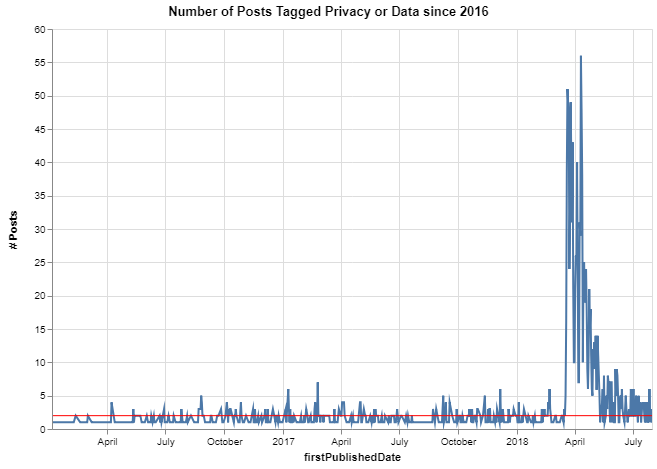

In [187]:
chart=alt.Chart(privacy_day).mark_line().encode(
    x='firstPublishedDate:T',
    y='NumberOfPosts:Q',
    tooltip=['NumberOfPosts'],
   
).properties(
    title='Number of Posts Tagged Privacy or Data since 2016',
    height=400,
    width=600
).interactive()
chart.encoding.y.title = '# Posts'

rule = alt.Chart(privacy_day).mark_rule(color='red').encode(
    y='median(NumberOfPosts)',
    size=alt.value(1)
)




chart+rule

### Which is the most well recevied theme - post and pre scandal?

In [189]:
prescandal_posts=privacy_posts[privacy_posts['firstPublishedDate']<pd.to_datetime('2018-03-17')]
postscandal_posts=privacy_posts[privacy_posts['firstPublishedDate']>=pd.to_datetime('2018-03-17')]

In [190]:
prescandal_posts_count=prescandal_posts.groupby(['clusters'])['id'].count().reset_index().rename(columns={'id':'NumberOfPosts'})
postscandal_posts_count=postscandal_posts.groupby(['clusters'])['id'].count().reset_index().rename(columns={'id':'NumberOfPosts'})


In [196]:
prescandal_posts_agg=prescandal_posts.groupby(['clusters'])['totalClapCount','recommends','readingTime','wordCount'].mean().reset_index()
prescandal_posts_agg=prescandal_posts_agg.rename(columns={'totalClapCount':'Avg Claps','recommends':'Avg Recommends','readingTime':'Avg Reading Time','wordCount':'Avg word count'})

,clusters,Avg Claps,Avg Recommends,Avg Reading Time,Avg word count
0,0,18.414894,5.042553,3.567373,849.361702
1,1,20.484375,10.687500,3.706206,903.265625
2,2,40.071429,5.571429,3.645867,894.857143
3,3,3.000000,2.888889,1.951607,482.333333
4,4,0.909091,0.623377,2.991946,621.935065
5,5,131.805195,16.285714,4.607690,1137.350649
6,6,0.000000,0.000000,2.336583,585.333333
7,7,29.500000,12.000000,2.502830,570.500000
8,8,5.450000,2.525000,1.919819,464.475000
9,9,27.747619,16.976190,2.170103,491.728571


In [198]:
postscandal_posts_agg=postscandal_posts.groupby(['clusters'])['totalClapCount','recommends','readingTime','wordCount'].mean().reset_index()
postscandal_posts_agg=postscandal_posts_agg.rename(columns={'totalClapCount':'Avg Claps','recommends':'Avg Recommends','readingTime':'Avg Reading Time','wordCount':'Avg word count'})

In [202]:
postscandal=pd.merge(postscandal_posts_agg,postscandal_posts_count,on='clusters',how='outer')
postscandal['type']='postscandal'

In [201]:
prescandal=pd.merge(prescandal_posts_agg,prescandal_posts_count,on='clusters',how='outer')
prescandal['type']='prescandal'

In [203]:
agg_data=pd.concat([postscandal,prescandal],axis=0)
agg_data

,clusters,Avg Claps,Avg Recommends,Avg Reading Time,Avg word count,NumberOfPosts,type
0,0,100.511364,10.096591,4.370592,1071.755682,176,postscandal
1,1,80.226190,6.952381,4.062436,991.261905,84,postscandal
2,2,125.608696,16.228261,3.803322,930.108696,92,postscandal
3,3,78.488722,9.248120,3.064744,730.631579,133,postscandal
4,4,12.520000,2.000000,3.108667,657.200000,25,postscandal
5,5,142.180392,11.172549,3.718764,910.960784,255,postscandal
6,6,0.708333,0.125000,1.996384,526.833333,24,postscandal
7,7,118.188312,12.603896,3.084487,753.175325,154,postscandal
8,8,60.666667,6.333333,3.640278,861.250000,12,postscandal
9,9,38.430493,3.739910,2.021519,476.919283,223,postscandal


In [204]:
agg_data.to_csv("Aggreagted_data.csv",index=False)